# ALFA-BD - Predição da Avaliação de Fluência em Leitura com Naive Bayes

## Leitura de texto dos Alunos do 2ª e 3º Anos do Fundamental

#### Autor: TS#03


### Algoritmo de Naive Bayes

Gera uma tabela de probabilidades entre o texto (feature) e a avaliação (label)

#### Bibliotecas

In [23]:
import random
import nltk
import re

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, train_test_split

## Carregamento da Base de Dados

In [24]:
dataset = pd.read_csv('dataset/speech_to_text.csv')

In [25]:
dataset.shape

(13, 6)

In [26]:
dataset.head()

,id,ano,instituicao,genero,avaliacao,texto
0,9,3,publica,menina,regular,a coisa a casa do avô de Pedro era uma dessas ...
1,3,2,publica,menina,bom,a coisa a casa do avô de Pedro era uma dessas ...
2,11,2,publica,menino,regular,a coisa a casa do avô de Pedro era uma dessas ...
3,12,3,publica,menino,regular,a coisa a casa da vovó de Pedro era uma dessas...
4,5,2,publica,menina,regular,a casa do vovô de Pedro era muito uma de cada ...


## Verificando Dados Desbalanceados

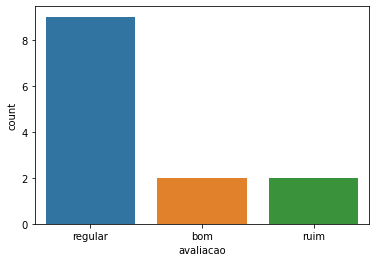

In [27]:
sns.countplot(x=dataset['avaliacao']);

In [28]:
dataset['avaliacao'] = dataset['avaliacao'].factorize(['bom', 'regular', 'ruim'])[0]

X = dataset['texto'].values
y = dataset['avaliacao'].values

## Pré Processamento

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"[^a-zA-Z.!?]", ' ', text)
    text = re.sub(r" +", ' ', text)
    return text

In [30]:
X = [ clean_text(text) for text in X ]

vectorizer = CountVectorizer(analyzer="word")

# calcula a frequência de todas as palavras da lista de textos 
X = vectorizer.fit_transform(X)

## Treinamento e Teste

In [31]:
# Criando base de trienamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [32]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [33]:
predictions = model.predict(X_test)
predictions

array([1, 1, 1])

In [34]:
y_test

array([0, 1, 1])

### Avaliação

Nota-se que o modelo obteve overfiting na classe 1 (regular), pois é a classe que mais possui amostras de exemplos.

In [35]:
classes = ['bom','regular','ruim']
print (metrics.classification_report(y_test, predictions, [0, 1, 2]))
print (f'Acurácia: {accuracy_score(predictions, y_test)}')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67         3
   macro avg       0.22      0.33      0.27         3
weighted avg       0.44      0.67      0.53         3

Acurácia: 0.6666666666666666


/home/aline/Repositorios/ITA/ibpl-alfa-bd-2021/audioanalysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/aline/Repositorios/ITA/ibpl-alfa-bd-2021/audioanalysis/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aline/Repositorios/ITA/ibpl-alfa-bd-2021/audioanalysis/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [36]:
cm = confusion_matrix(predictions, y_test)

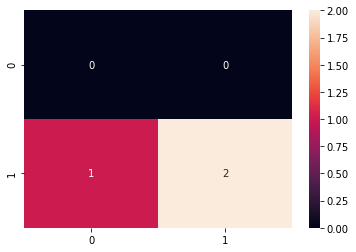

In [37]:
sns.heatmap(cm, annot=True);

## Sobreamostragem (oversampling)

Técnica para imputar dados em datasets desbalanceados, cria-se amostras sintéticas utilizando algoritmos baseados em calculos de similaridade.

#### Criando amostras sintéticas para as classes minoritárias

In [38]:
from imblearn.over_sampling import SMOTE, RandomOverSample

In [104]:
smote = SMOTE(k_neighbors=1)
X_over, y_over = smote.fit_resample(X, y)

In [105]:
X_over.shape, y_over.shape

((27, 281), (27,))

In [106]:
np.unique(y_over, return_counts=True)

(array([0, 1, 2]), array([9, 9, 9]))

In [107]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([2, 9, 2]))

#### Criandos amostras sintéticas para todas as classes

Essa parte não foi executada no próximo treinamento pois as amostras geradas estão muito parecidas ocasionando Overfitting no modelo.

In [103]:
smote = SMOTE(sampling_strategy={0: 15, 1: 15, 2: 15})
X_over, y_over = smote.fit_resample(X_over, y_over)

In [97]:
X_over.shape, y_over.shape

((45, 281), (45,))

In [98]:
# 30 amostras de cada classe
np.unique(y_over, return_counts=True)

(array([0, 1, 2]), array([15, 15, 15]))

#### Retreinando o modelo

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over)

model = MultinomialNB()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
predictions

array([2, 0, 2, 1, 0, 0])

In [109]:
y_test

array([2, 0, 2, 1, 1, 0])

#### Avaliação

In [110]:
print (metrics.classification_report(y_test, predictions, [0, 1, 2]))
print (f'Acurácia: {accuracy_score(predictions, y_test)}')

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6

Acurácia: 0.8333333333333334


/home/aline/Repositorios/ITA/ibpl-alfa-bd-2021/audioanalysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


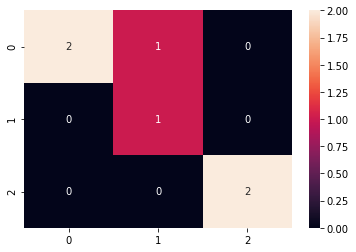

In [111]:
cm = confusion_matrix(predictions, y_test)
sns.heatmap(cm, annot=True);